# Zmiany w kodzie
Tak jak pisałem w poprzednim punkcie kontrolnym, przeniosłem cały kod do osobnego pliku. 
Wprowadziłem również różne refaktoryzacje, wektoryzacje oraz poprawki kodu - liczyłem nie do końca poprawny gradient w pierwszej warstwie sieci.
Prawdopodobnie z tego powodu miałem problemy ze zbieżnością w zadaniu `steps`.

In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Ten kawałek kodu jest potrzebny do przeładowywania pliku po zmianie bez restartu kernela.
`import` powoduje kompilację do bytecode i trzeba "ręcznie" przeładować moduł.

In [293]:
from importlib import reload
import mio
reload(mio)
from mio import *

# Nowy kod
Korzystam dużo z pythonowych *list comprehension*, ale jest to w dużej mierze nieuniknione. Zdecydowałem się w przypadku metody pędu zaimplementować wersję z batchowaniem, w przypadku RMSProp dla pełnego gradientu.

## Metoda pędu (momentum)
Łączenie kilku metod w jedną nie jest bardzo eleganckim rozwiązaniem, ale co poradzić.

```python
def momentum_method_batch(trainer, max_epoch, batch_size=32, momentum_rate=0.9, rate=1e-3):
    m_g, m_gb = trainer.nn.get_zero_grads()
    for i in range(max_epoch):
        indexes = np.random.randint(trainer.x.shape[0], size=batch_size)
        x_chosen = trainer.x[indexes]
        y_chosen = trainer.y[indexes]
        g, gb = trainer.nn.backpropagate(x_chosen, y_chosen)
        m_g  = [mgi  * momentum_rate - rate * gi  for mgi, gi   in zip(m_g, g)]
        m_gb = [mgbi * momentum_rate - rate * gbi for mgbi, gbi in zip(m_gb, gb)]
        trainer.nn.apply_grad(m_g, m_gb)
```

## RMSProp
Standardowy detal implementacyjny, `eps` do blokowania dzielenia przez 0. 
Rozdzielenie biasów od wag bardzo wymusza bardzo niemiłą duplikację kodu.

```python
def rmsprop_method(trainer, max_epoch, slowdown_rate=0.9, rate=1e-3):
    eps = 0.0001
    slow_g , slow_gb = trainer.nn.get_zero_grads()
    for i in range(max_epoch):
        g, gb = trainer.nn.backpropagate(trainer.x, trainer.y)
        
        slow_g = [slowgi * slowdown_rate + (1-slowdown_rate)*gi*gi
            for slowgi, gi in zip(slow_g, g)]

        slow_gb = [slowgbi * slowdown_rate + (1-slowdown_rate)*gbi*gbi
            for slowgbi, gbi in zip(slow_gb, gb)]

        final_g = [- rate * gi / np.sqrt(slowgi + eps) 
            for slowgi, gi in zip(slow_g, g)]

        final_gb = [- rate * gbi / np.sqrt(slowgbi + eps) 
            for slowgbi, gbi in zip(slow_gb, gb)]

        trainer.nn.apply_grad(final_g, final_gb)
```

## Factory
Nie jestem zadowolony z tego kodu, ale łatwiej pozwala budować proste architektury.

In [ ]:
nnf = NNFactory(SigmoidLinearActivationStrategy(), LayerFactory(UniformInitializer()))

# Square Large
## Próba zejścia do 1 MSE

Dla tego zbioru zastosowałem metodę z pędem, z batchem `32` obserwacji. 

In [ ]:
dfsq = pd.read_csv("LAB1_DANE/regression/square-large-training.csv")
xsq = np.array(dfsq.iloc[:,1]).reshape((1000, 1))
ysq = np.array(dfsq.iloc[:,2]).reshape((1000, 1))

dfsq_test = pd.read_csv("LAB1_DANE/regression/square-large-test.csv")
xsq_test = np.array(dfsq_test.iloc[:,1]).reshape((300, 1))
ysq_test = np.array(dfsq_test.iloc[:,2]).reshape((300, 1))

nnsq = nnf.get((1, 32, 1))
nnsqt = Trainer(nnsq, xsq, ysq, x_test=xsq_test, y_test=ysq_test)
nnsqt.momentum_method_batch(100_000, batch_size=32, rate=0.01)

0.0002256552797995603


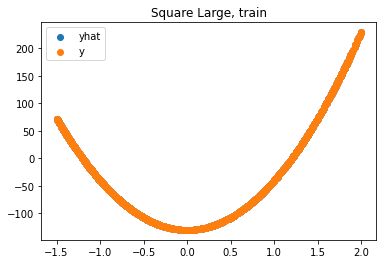

In [110]:
nnsqt.plot_results(title="Square Large")

Zbiór testowy wystaje znacznie poza treningowy. 
Na zbiorze treningowym sieci nie miały żadnych problemów, ale na testowym nie udało mi się zejść poniżej 300 MSE.

308.47474664718595


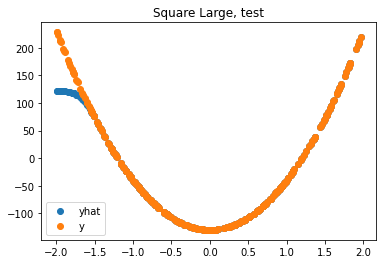

In [111]:
nnsqt.plot_results(title="Square Large", dataset="test")

## Testy prędkości zbieżności

In [327]:
nn_moment = nnf.get((1, 32, 1))
nn_moment_t = Trainer(nn_moment, xsq, ysq, tracker=TimeLossTracker(1000, MSE))
nn_moment_t.momentum_method_batch(100_000, batch_size=100, rate=0.001)

MSE at 24.03s: 0.032051288371316426

In [328]:

nn_batch = nnf.get((1, 32, 1))
nn_batch_t = Trainer(nn_batch, xsq, ysq, tracker=TimeLossTracker(1000, MSE))
nn_batch_t.train_random_batch(100_000, batch_size=100, rate=0.001)

MSE at 22.61s: 0.7249489050628437

In [329]:
nn_gradient = nnf.get((1, 32, 1))
nn_gradient_t = Trainer(nn_gradient, xsq, ysq, tracker=TimeLossTracker(100, MSE))
nn_gradient_t.train_gradient(10_000, rate=0.001)

MSE at 23.62s: 78.005830324630033

In [330]:
nn_rmsprop = nnf.get((1, 32, 1))
nn_rmsprop_t = Trainer(nn_rmsprop, xsq, ysq, tracker=TimeLossTracker(100, MSE))
nn_rmsprop_t.rmsprop_method(10_000, slowdown_rate=0.1, rate=0.001)

MSE at 23.79s: 2820.6711728791033

0.031333528323355
0.710208726150136
76.28216029701413
2779.8407258372513


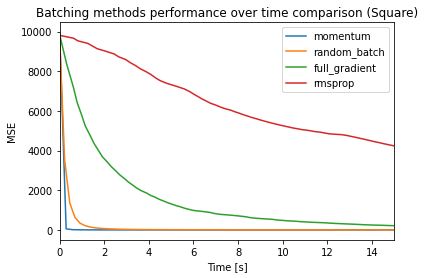

In [331]:
nn_moment_t.plot_progress()
nn_batch_t.plot_progress()
nn_gradient_t.plot_progress()
nn_rmsprop_t.plot_progress()
plt.legend(["momentum", "random_batch", "full_gradient", "rmsprop"])
plt.xlim((0, 15))
plt.title("Batching methods performance over time comparison (Square)")
plt.xlabel("Time [s]")
plt.ylabel("MSE")
plt.show()

0.031333528323355
0.710208726150136
76.28216029701413
2779.8407258372513


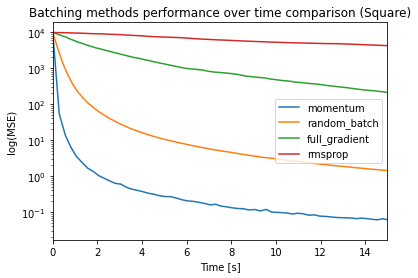

In [332]:
nn_moment_t.plot_progress()
nn_batch_t.plot_progress()
nn_gradient_t.plot_progress()
nn_rmsprop_t.plot_progress()
plt.legend(["momentum", "random_batch", "full_gradient", "rmsprop"])
plt.xlim((0, 15))
plt.title("Batching methods performance over time comparison (Square)")
plt.xlabel("Time [s]")
plt.ylabel("log(MSE)")
plt.yscale("log")
plt.show()

Pomimo tego, że każda iteracja jest wolniejsza, to metoda pędu zbiega znacznie szybciej.
Jak można się spodziewać, metody na pełnym gradiencie są znacznie wolniejsze (aż potrzebują skali logarytmicznej).
RMSProp okazuje się najwolniejszy, co prawdopodobnie oznacza, że gdzieś zrobiłem błąd, lub ten algorytm nie lubi tego zbioru.

# Steps Large
## Próba zejścia do 3 MSE

Dla tego zbioru zdecydowałem się skorzystać z RMSProp.
Sieci bardzo szybko zbiegały na poziom ~50 MSE, ale zejście do porządanych 3 MSE okazało się dużym problemem.
Przedstawione wyniki są łącznie z około godziny uczenia.
Jest możliwe, że udałoby się "douczyć" do tych 3 MSE, ale po poprzednim incydencie ze stepsami samo patrzenie na wykres mnie denerwuje.

In [228]:
dfst = pd.read_csv("LAB1_DANE/regression/steps-large-training.csv")
xst = np.array(dfst.iloc[:,1]).reshape((10000, 1))
yst = np.array(dfst.iloc[:,2]).reshape((10000, 1))

dfst_test = pd.read_csv("LAB1_DANE/regression/steps-large-test.csv")
xst_test = np.array(dfst_test.iloc[:,1]).reshape((1000, 1))
yst_test = np.array(dfst_test.iloc[:,2]).reshape((1000, 1))

nnst = nnf.get((1, 16, 16, 1))
nnstt = Trainer(nnst, xst, yst, x_test=xst_test, y_test=yst_test)

In [ ]:

nnstt.rmsprop_method(100000, slowdown_rate=0.9, rate=0.01)

5.152282030629234


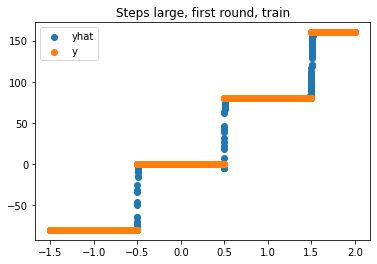

In [266]:
nnstt.plot_results("Steps large, first round")

4.154017006914467


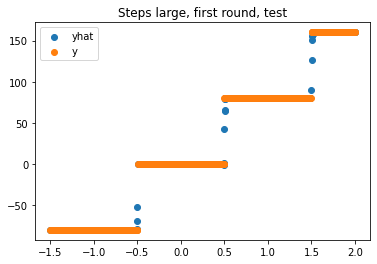

In [267]:
nnstt.plot_results("Steps large, first round", dataset="test")

In [268]:
nnstt.rmsprop_method(100000, slowdown_rate=0.9, rate=0.01)

3.846520536186266


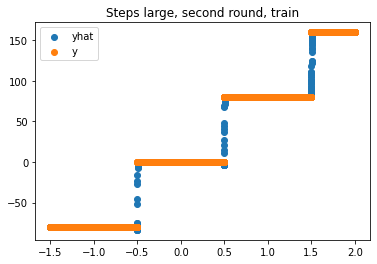

In [269]:
nnstt.plot_results("Steps large, second round")

2.9494109351525397


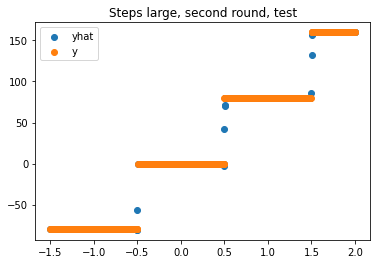

In [270]:
nnstt.plot_results("Steps large, second round", dataset="test")

## Testy prędkości zbieżności

In [342]:
nn_moment = nnf.get((1, 32, 1))
nn_moment_t = Trainer(nn_moment, xst, yst, tracker=TimeLossTracker(1_000, MSE))
nn_moment_t.momentum_method_batch(100_000, batch_size=100, rate=0.001)

MSE at 25.41s: 35.695730528627315

In [343]:

nn_batch = nnf.get((1, 32, 1))
nn_batch_t = Trainer(nn_batch, xst, yst, tracker=TimeLossTracker(1_000, MSE))
nn_batch_t.train_random_batch(100_000, batch_size=100, rate=0.001)

MSE at 22.99s: 95.154039621970548

In [344]:
nn_gradient = nnf.get((1, 32, 1))
nn_gradient_t = Trainer(nn_gradient, xst, yst, tracker=TimeLossTracker(10, MSE))
nn_gradient_t.train_gradient(1_000, rate=0.001)

MSE at 20.15s: 663.7953260493351

In [345]:
nn_rmsprop = nnf.get((1, 32, 1))
nn_rmsprop_t = Trainer(nn_rmsprop, xst, yst, tracker=TimeLossTracker(10, MSE))
nn_rmsprop_t.rmsprop_method(1_000, slowdown_rate=0.1, rate=0.001)

MSE at 20.10s: 5837.1345612666785

35.998524628039696
94.79823744666173
661.5392600246684
5820.705346237516


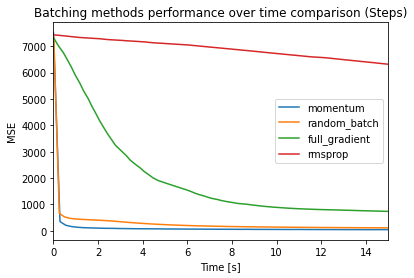

In [346]:
nn_moment_t.plot_progress()
nn_batch_t.plot_progress()
nn_gradient_t.plot_progress()
nn_rmsprop_t.plot_progress()
plt.legend(["momentum", "random_batch", "full_gradient", "rmsprop"])
plt.xlim((0, 15))
plt.title("Batching methods performance over time comparison (Steps)")
plt.xlabel("Time [s]")
plt.ylabel("MSE")
plt.show()

35.998524628039696
94.79823744666173
661.5392600246684
5820.705346237516


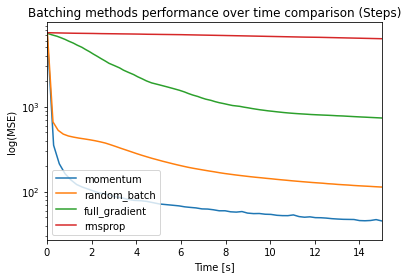

In [347]:
nn_moment_t.plot_progress()
nn_batch_t.plot_progress()
nn_gradient_t.plot_progress()
nn_rmsprop_t.plot_progress()
plt.legend(["momentum", "random_batch", "full_gradient", "rmsprop"])
plt.xlim((0, 15))
plt.title("Batching methods performance over time comparison (Steps)")
plt.xlabel("Time [s]")
plt.ylabel("log(MSE)")
plt.yscale("log")
plt.show()

Podobna historia na zbiorze steps, więc pewnie mój RMSProp ma jakiś problem.

# Multimodal Large
## Próba zejścia poniżej 9 MSE

Zbiór multimodal large, był z kolei całkowicie bezproblemowy. 
Po dobraniu odpowiednio dużej sieci i odpowiedniego `learning_rate` sieć nauczyła się zbioru.
Skorzystałem z losowego batchowania dla urozmaicenia.

In [260]:
dfmm = pd.read_csv("LAB1_DANE/regression/multimodal-large-training.csv")
xmm = np.array(dfmm.iloc[:,0]).reshape((10000, 1))
ymm = np.array(dfmm.iloc[:,1]).reshape((10000, 1))

dfmm_test = pd.read_csv("LAB1_DANE/regression/multimodal-large-test.csv")
xmm_test = np.array(dfmm_test.iloc[:,0]).reshape((1000, 1))
ymm_test = np.array(dfmm_test.iloc[:,1]).reshape((1000, 1))

nnmm= nnf.get((1, 96, 64, 1))
nnmmt = Trainer(nnmm, xmm, ymm, x_test=xmm_test, y_test=ymm_test)
nnmmt.train_random_batch(200000, batch_size=64, rate=0.001)

7.450762656517218


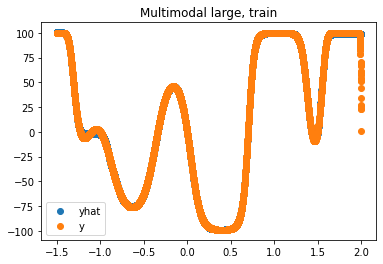

In [261]:
nnmmt.plot_results("Multimodal large")

2.4243362376599213


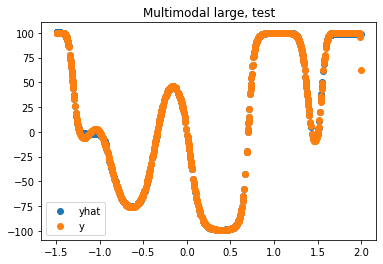

In [262]:
nnmmt.plot_results("Multimodal large", dataset="test")

## Porównanie szybkości zbieżności
Na zbiorze multimodal wykonam porównanie momentu i losowego batchowania.
Zbiór jest za duży, żeby uczyć na nim pełny gradient w rozsądnym czasie

In [339]:
nn_moment = nnf.get((1, 96, 64, 1))
nn_moment_t = Trainer(nn_moment, xmm, ymm, tracker=TimeLossTracker(1000, MSE))
nn_moment_t.momentum_method_batch(100_000, batch_size=32, rate=0.001)


MSE at 47.23s: 5.4800455158132171

In [340]:

nn_random_batch = nnf.get((1, 96, 64, 1))
nn_random_batch_t = Trainer(nn_random_batch, xmm, ymm, tracker=TimeLossTracker(1000, MSE))
nn_random_batch_t.train_random_batch(100_000, batch_size=32, rate=0.001)

MSE at 43.45s: 9.2527435581747323

6.620834658035339
9.242867084085859


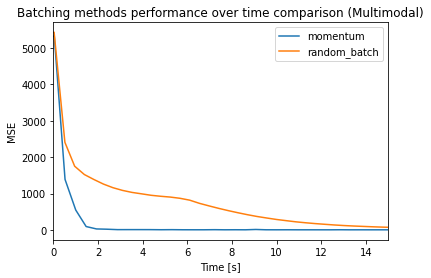

In [341]:
nn_moment_t.plot_progress()
nn_random_batch_t.plot_progress()
plt.legend(["momentum", "random_batch"])
plt.xlim((0, 15))
plt.title("Batching methods performance over time comparison (Multimodal)")
plt.xlabel("Time [s]")
plt.ylabel("MSE")
plt.show()